In [163]:
import networkx as nx
import beessna.bib.preprocessing as prep
import numpy as np
import pandas as pd
import json

from bb_binary import load_frame_container, Repository
from pandas import Series, DataFrame
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
def get_files(path):
    repo = Repository(path)
    file = list(repo.iter_fnames())
    a = [f.split('/')[-1].split("_")[1] for f in file]
    l = len(a)/4
    npa = np.array(file).reshape(l,4)
    return npa

In [54]:
def bee_pairs_to_timeseries(df):
    close = df[['frame_idx', 'id_x', 'id_y']]
    close['pair'] = list(zip(close.id_x, close.id_y))
    u_pairs = close.pair.unique()
    cols = len(df.frame_idx.unique())
    dft = DataFrame(0, index=u_pairs, columns=np.arange(cols))
    gr = close.groupby('frame_idx')

    for i, group in gr:
        l = group['pair']
        dft.loc[l,i] = 1

    return dft

In [118]:
# 0.9, 160, "08", 3
def f(c,d,m,l):
    filename = "{}month-{}dist-{}conf-{}len-1h".format(m,d,str(c).replace('.',''),l)
    print(filename)
    f = "data/1h/"
    p = "2015" + m + "2215"
    CONFIDENCE = c
    DISTANCE = d
    xmax = 3000
    ymax = 4000
    LENGTH = l
    path = f+p

    files = get_files(path)

    
    dataframes = [DataFrame(), DataFrame(), DataFrame(), DataFrame()]

    for e, file_list in enumerate(files):
        
        for i in list(range(4)):
            fc = load_frame_container(file_list[i])
            df = prep.get_dataframe(fc)
            df = prep.calcIds(df,CONFIDENCE)
            df['frame_idx'] = df['frame_idx'] + e*1024

            camIdx = int(file_list[i].split("/")[-1].split("_")[1])
            dataframes[camIdx] = pd.concat([dataframes[camIdx], df])
        
    # cam 0 und cam1 nach rechts verschieben
    dataframes[0].xpos = dataframes[0].xpos + xmax
    dataframes[1].xpos = dataframes[1].xpos + xmax

    # Seiten zusammenfugen
    side0 = pd.concat([dataframes[3], dataframes[0]])
    side1 = pd.concat([dataframes[2], dataframes[1]])

    close1 = prep.get_close_bees(side0, DISTANCE)
    close2 = prep.get_close_bees(side1, DISTANCE)

    close = pd.concat([close1,close2])

    p = bee_pairs_to_timeseries(close)

    return p

In [119]:
t = f(0.95, 160, "09", 3)

09month-160dist-095conf-3len-1h


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [120]:
t.head()

,0,1,2,3,4,5,6,7,8,9,...,11254,11255,11256,11257,11258,11259,11260,11261,11262,11263
"(1229, 1445)",1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(585, 1445)",1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
"(389, 560)",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(596, 2153)",1,1,1,1,1,1,1,0,0,0,...,0,0,1,1,1,1,1,1,1,1
"(2153, 3629)",1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [107]:
timeslices_s = np.arange(1,60)*3

In [108]:
ts_min_1 = np.arange(1,6)*60*3

In [109]:
ts_min_2 = np.arange(1,7)*10*60*3

In [113]:
tw = np.concatenate((timeslices_s, ts_min_1, ts_min_2))

In [134]:
def extract_interactions(dft, minlength):
    kette = dft.apply(get_ketten, axis=1, args=["0"])
    kk = kette.apply(lambda x: [len(item) for item in x])
    kk = kk.apply(lambda x: len([item for item in x if item >= minlength]))
    return kk[kk > 0]

In [136]:
def get_ketten(kette, val):
    kette = kette.apply(str)
    s = kette.str.cat(sep='')
    ss = s.split(val)
    return [x for x in ss if len(x) > 0]

In [149]:
LENGTH = 3

graphs = []
for window in tw:
    print(window)
    part = t.ix[:,:window-1]
    edges = extract_interactions(part,LENGTH)
    graphs.append(prep.create_graph2(edges))

3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90
93
96
99
102
105
108
111
114
117
120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
360
540
720
900
1800
3600
5400
7200
9000
10800


In [150]:
len(graphs)

70

In [152]:
def network_statistics(g):
    nodes = nx.number_of_nodes(G)
    edges = nx.number_of_edges(G)
    degrees = G.degree().values()
    average_degree = sum(degrees)/nodes
    density = nx.density(G)
    cc = nx.average_clustering(G)
    components = nx.number_connected_components(G)
    
    # only for biggest subgraph
    Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    G0 = Gcc[0]
    average_shortest_path = nx.average_shortest_path_length(G0)
    diameter = nx.diameter(G0)

    return {'nodes': nodes, 'edges': edges, 'av_deg': average_degree, 'density': density,
           'cc': cc, 'components': components, 'diameter': diameter,
            'av_shortest_path':average_shortest_path, 'degree': degrees}

In [ ]:
## Statistik Networks

In [153]:
l_stat = []

In [154]:
for graphsG in enumerate(graphs):
    stat_map = network_statistics(G)
    stat_map.update({'window_size': tw[e]})
    l_stat.append(Series(stat_map))

In [155]:
df3 = DataFrame(l_stat)

In [156]:
df3.to_csv("1h_09_95_160px_windowsize.csv", sep=";")

In [158]:
df3.shape

(70, 10)

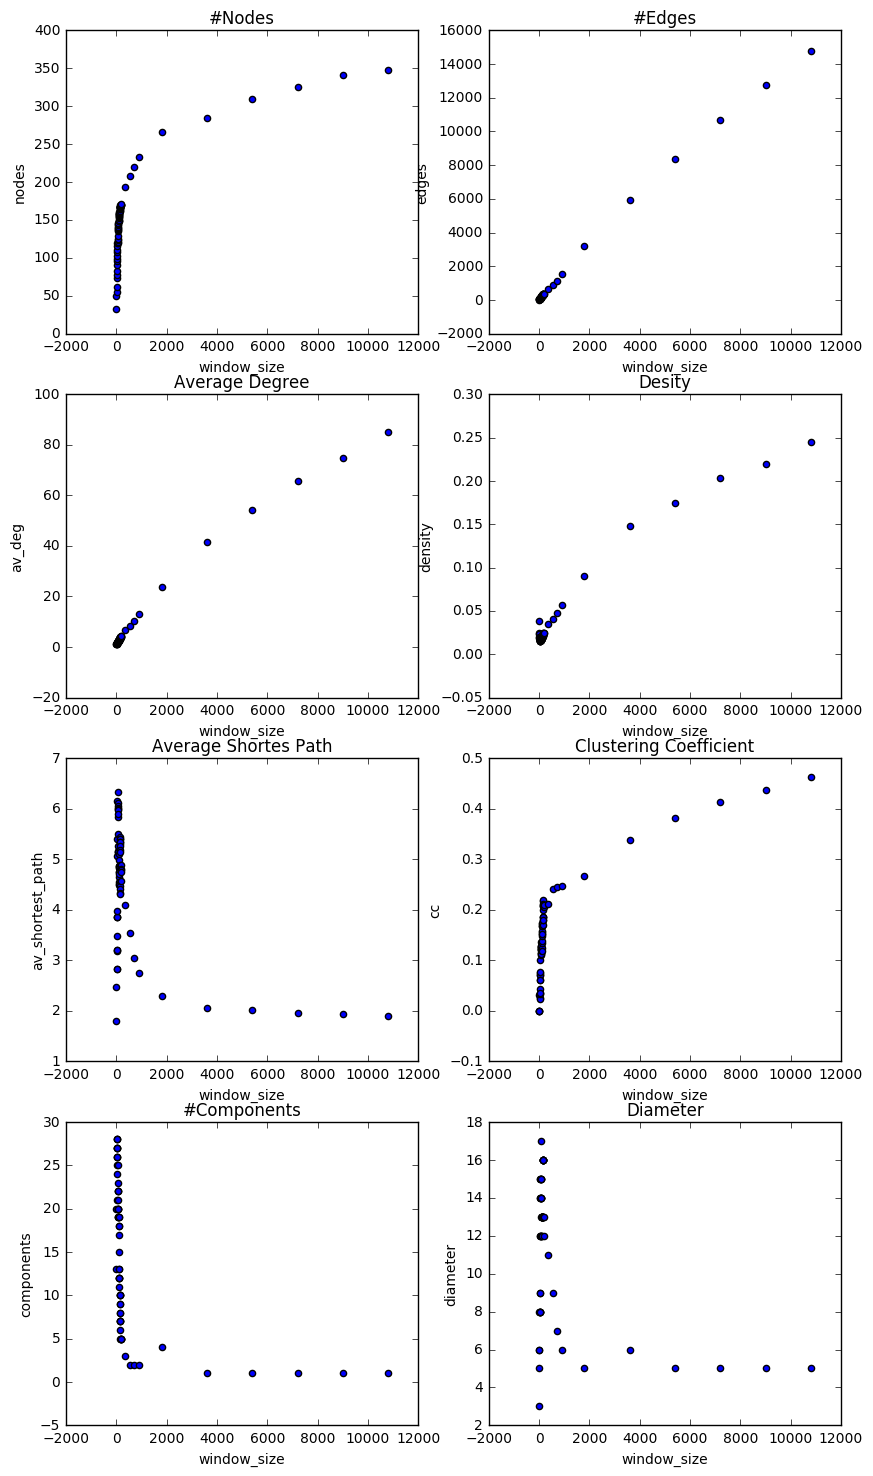

In [171]:
# data = pd.read_csv("1h_09_95_160px_windowsize.csv", sep=";")
# data = data.drop(['degree', 'Unnamed: 0'], 1)
# for c in data:
#     #print(c)
#     data.plot.scatter(x='window_size', y=c, title=c, s=2)

df = pd.read_csv("1h_09_95_160px_windowsize.csv", sep=";")

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,18), )

xx = 'window_size'

df.plot.scatter(ax=axes[0,0], x=xx, y='nodes')
axes[0,0].set_title('#Nodes')

df.plot.scatter(ax=axes[0,1], x=xx, y='edges')
axes[0,1].set_title('#Edges')

df.plot.scatter(ax=axes[1,0], x=xx, y='av_deg')
axes[1,0].set_title('Average Degree')

df.plot.scatter(ax=axes[1,1], x=xx, y='density')
axes[1,1].set_title('Desity')

df.plot.scatter(ax=axes[2,0], x=xx, y='av_shortest_path')
axes[2,0].set_title('Average Shortes Path')

df.plot.scatter(ax=axes[2,1], x=xx, y='cc')
axes[2,1].set_title('Clustering Coefficient')

df.plot.scatter(ax=axes[3,0], x=xx, y='components')
axes[3,0].set_title('#Components')

df.plot.scatter(ax=axes[3,1], x=xx, y='diameter')
axes[3,1].set_title('Diameter')

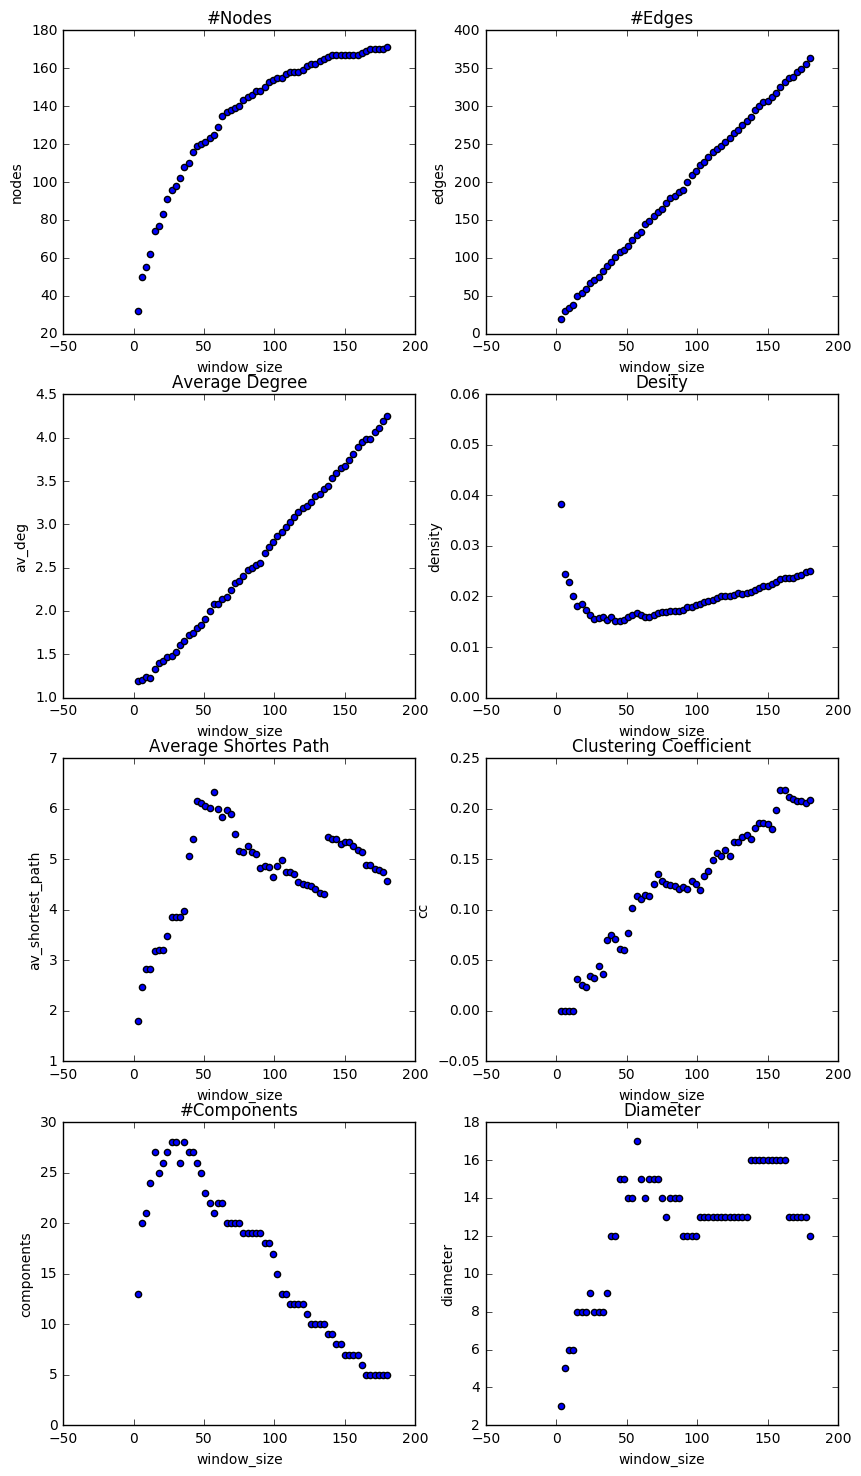

In [175]:
df = df.ix[:59]



fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,18), )

xx = 'window_size'

df.plot.scatter(ax=axes[0,0], x=xx, y='nodes')
axes[0,0].set_title('#Nodes')

df.plot.scatter(ax=axes[0,1], x=xx, y='edges')
axes[0,1].set_title('#Edges')

df.plot.scatter(ax=axes[1,0], x=xx, y='av_deg')
axes[1,0].set_title('Average Degree')

df.plot.scatter(ax=axes[1,1], x=xx, y='density')
axes[1,1].set_title('Desity')

df.plot.scatter(ax=axes[2,0], x=xx, y='av_shortest_path')
axes[2,0].set_title('Average Shortes Path')

df.plot.scatter(ax=axes[2,1], x=xx, y='cc')
axes[2,1].set_title('Clustering Coefficient')

df.plot.scatter(ax=axes[3,0], x=xx, y='components')
axes[3,0].set_title('#Components')

df.plot.scatter(ax=axes[3,1], x=xx, y='diameter')
axes[3,1].set_title('Diameter')

In [ ]:
testdf = DataFrame(np.array([0,111,123,0,222,234,0,333,345,1,666,678,1,777,789,1,888,890]).reshape(6,3),
                   columns=["frame_idx", "id", "xpos"])

In [197]:
testdf

,frame_idx,id,xpos
0,0,111,123
1,0,222,234
2,0,333,345
3,1,666,678
4,1,777,789
5,1,888,890


In [200]:
m = pd.merge(testdf, testdf, on='frame_idx')

In [201]:
m = m[m.id_x < m.id_y]

In [202]:
m

,frame_idx,id_x,xpos_x,id_y,xpos_y
1,0,111,123,222,234
2,0,111,123,333,345
5,0,222,234,333,345
10,1,666,678,777,789
11,1,666,678,888,890
14,1,777,789,888,890
